In [3]:
### Import the datasets
from datasets import load_dataset
dataset = load_dataset("cnn_dailymail", '1.0.0')

Found cached dataset cnn_dailymail (/home/rutts07/.cache/huggingface/datasets/cnn_dailymail/1.0.0/1.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de)


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
### Import the necessary packages
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from rouge import Rouge
import random
import re
import unicodedata
import itertools
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
### Load and preprocess the train dataset
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
    "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
    "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
    "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
    "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
    "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
    "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
    "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
    "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
    "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
    "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
    "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
    "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
    "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
    "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
    "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
    "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
    "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
    "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
    "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
    "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
    "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
    "you're": "you are", "you've": "you have"}

def unicodeToAscii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')
    
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub('"','', s)
    s = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in s.split(" ")])
    s = re.sub(r"'s\b","", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

def LoadArticlesAndSummaries(dataset, type, count=0, max_article_length=0, max_summary_length=0):
    pairs = []
    
    if count > len(dataset[type]) or count == 0:
        count = len(dataset[type])
    
    # Choose articles and summaries with length less than max_article_length and max_summary_length
    i = 0
    num_sents = 0
    
    if (max_article_length == 0 or max_summary_length == 0):
        for i in range(count):
            article = normalizeString(dataset[type][i]['article'])
            summary = normalizeString(dataset[type][i]['highlights'])
            pairs.append([article, summary])
            
        return pairs
            
    for i in range(len(dataset[type])):
        if (num_sents >= count):
            break
        
        if (len(dataset[type][i]['article'].split()) <= max_article_length and len(dataset[type][i]['highlights'].split()) <= max_summary_length):
            pair = []
            pair.append(normalizeString(dataset['train'][i]['article']))
            pair.append(normalizeString(dataset['train'][i]['highlights']))
            pairs.append(pair)
            num_sents += 1
            # articles.append(normalizeString(dataset['train'][i]['article']))
            # summaries.append(normalizeString(dataset['train'][i]['highlights']))
        
    return pairs

In [6]:
### Create the vocabulary

# Default word tokens
PAD_token = 0  # Used for padding short sentences
SOS_token = 1  # Start-of-sentence token
EOS_token = 2  # End-of-sentence token
UNK_token = 3  # Unknown word token

class Vocab(object):
    def __init__(self, pairs):
        super(Vocab, self).__init__()
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS", UNK_token: "UNK"}
        self.num_words = 4  # Count SOS, EOS, PAD
        self.pairs = pairs
        
    def wrd2idx(self, word):
        if word in self.word2index:
            return self.word2index[word]
        else:
            return UNK_token
        
    def idx2wrd(self, idx):
        if idx in self.index2word:
            return self.index2word[idx]
        else:
            return self.index2word[UNK_token]
        
    def add_sentence(self, sentence):
        for word in sentence.split(' '):
            self.add_word(word)
            
    def add_word(self, word):
        if word in self.word2index:
            self.word2count[word] += 1
            
        else:
            self.word2index[word] = self.num_words
            self.index2word[self.num_words] = word
            self.word2count[word] = 1
            self.num_words += 1
            
    def build_vocab(self):        
        for pair in self.pairs:
            self.add_sentence(pair[0])   # Add only the article to the vocabulary
            # self.addSentence(pair[1])
            
        self.num_words = len(self.word2index)
        print("Vocabulary created with %d words ..." % self.num_words)
        # return self.num_words
    
    def vocab_size(self):
        return self.num_words
    
    # Modify the vocabulary to include OOV words for copy mechanism
    def extend_vocab(self, oovs):
        indices = []
        for i in range(len(oovs)):
            indices.append(self.num_words + i)
        oov_dict = dict(zip(indices, oovs))
        new_vocab = {**self.index2word, **oov_dict}
        # new_vocab = dict(self.index2word.items() + oov_dict.items())           
        # print("Vocabulary extended with %d words ..." % len(oovs))
        return new_vocab
    
    def encode_article(self, sentence, oovs=[]):
        word2ids = []   
        
        for word in sentence.split(" "):
            word2id = self.wrd2idx(word)
            if word2id == UNK_token:
                if word not in oovs:
                    oovs.append(word)
                word2ids.append(self.num_words + oovs.index(word))   
            else:
                word2ids.append(word2id)
                
        return word2ids, oovs
    
    def encode_summary(self, sentence, oovs):
        word2ids = []
        for word in sentence.split(" "):
            if word in self.word2index:
                word2ids.append(self.word2index[word])
                
            else:
                if word in oovs:
                    word2ids.append(self.num_words + oovs.index(word))
                else:
                    word2ids.append(UNK_token)
                    
        return word2ids
    
    def decode_idx2words(self, word2ids, oovs):
        words = []
        new_vocab = self.extend_vocab(oovs)
        
        for word2id in word2ids:
            if word2id in new_vocab:
                words.append(new_vocab[word2id])
            else:
                words.append("UNK")
                
        return words
    
    def trim_vocab(self, min_count=0): 
        # Re-initialize dictionaries 
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS", UNK_token: "UNK"}
        self.num_words = 4  # Count SOS, EOS, PAD
               
        for pair in self.pairs:
            self.add_sentence(pair[0])
            # self.add_sentence(pair[1])

        # Remove words below a certain count threshold
        keep_words = []
        
        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)
               
        # Re-initialize dictionaries 
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS", UNK_token: "UNK"}
        self.num_words = 4  # Count SOS, EOS, PAD
        
        for word in keep_words:
            self.add_word(word)
            
        self.num_words = len(keep_words)
        # print("Vocabulary trimmed to %d words ..." % self.num_words)
        # return self.words

In [7]:
### Define the device
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")    # "cuda" if USE_CUDA else "cpu"
torch.cuda.get_device_name(torch.cuda.current_device())
torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [8]:
### Define utility functions
def trimRareWords(vocab, MIN_COUNT=0):
    init_num_words = vocab.vocab_size()
    vocab.trim_vocab(MIN_COUNT)  
    final_num_words = vocab.vocab_size()
    print('Trimmed from {} words to {} words, removing {} words'.format(init_num_words, final_num_words, init_num_words - final_num_words))

### Perform length analysis on the dataset
def data_analysis(pairs):
      print("Number of article-summary pairs : %d" % len(pairs))
      
      article_word_count = []
      summary_word_count = []

      # populate the lists with sentence lengths
      for i in range(len(pairs)):
            article_word_count.append(len(pairs[i][0].split()))
            summary_word_count.append(len(pairs[i][1].split()))      

      length_df = pd.DataFrame({'text':article_word_count, 'summary': summary_word_count})
      length_df.hist(bins = 30)
      plt.show()
      
# Max-Article-length = 400
# Max-Summary-length = 100

Number of article-summary pairs : 5000


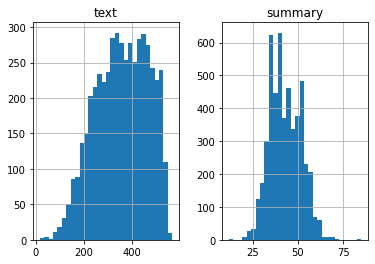

In [9]:
pairs = LoadArticlesAndSummaries(dataset, 'train', 5000, 512, 256)
data_analysis(pairs)

In [10]:
# Build Vocabulary with the trimmed dataset
vocab = Vocab(pairs)
vocab.build_vocab()
trimRareWords(vocab, 10)

Vocabulary created with 44463 words ...
Trimmed from 44463 words to 11230 words, removing 33233 words


In [11]:
# Create Batch Generator 
def zeroPadding(l, fillvalue=PAD_token):
    return list(itertools.zip_longest(*l, fillvalue=fillvalue))

def binaryMatrix(l, value=PAD_token):
    m = []
    for i, seq in enumerate(l):
        m.append([])
        for token in seq:
            if token == value:
                m[i].append(0)
            else:
                m[i].append(1)
                
    return m

def batch_article(article_indexes_batch):
    lengths = torch.tensor([len(indexes) for indexes in article_indexes_batch], device='cpu')
    padList = zeroPadding(article_indexes_batch)
    padVar = torch.LongTensor(padList)
    return padVar, lengths

def batch_summary(summary_indexes_batch):
    max_target_len = max([len(indexes) for indexes in summary_indexes_batch])
    padList = zeroPadding(summary_indexes_batch)
    mask = binaryMatrix(padList)
    mask = torch.BoolTensor(mask) 
    padVar = torch.LongTensor(padList)
    return padVar, mask, max_target_len 

# Returns all items for a given batch of pairs
def batch2TrainData(voc, pair_batch):
    pair_batch.sort(key=lambda x: len(x[0].split(" ")), reverse=True)
    art_ids, sum_ids, oovs = [], [], []
    
    for pair in pair_batch:
        art_id, oovs = voc.encode_article(pair[0], oovs)
        sum_id = voc.encode_summary(pair[1], oovs)
        
        art_ids.append(art_id)
        sum_ids.append(sum_id)
        
    max_oov_len = len(oovs)
    
    inp_ids, inp_len = batch_article(art_ids)
    out_ids, mask, max_out_len = batch_summary(sum_ids)
    return inp_ids, inp_len, oovs, out_ids, mask, max_out_len, max_oov_len

In [12]:
# Example for validation
small_data = pairs[:100]
small_batch_size = 5
batches = batch2TrainData(vocab, [random.choice(small_data) for _ in range(small_batch_size)])
input_variable, lengths, oovs, target_variable, mask, max_target_len, max_oov_len = batches
new_vocab = vocab.extend_vocab(oovs)

# input_variable = input_variable             # B X L
# target_variable = target_variable           # B X L

# print("input_variable:", input_variable, "\n")
# print("lengths:", lengths, "\n")
# print("target_variable:", target_variable, "\n")
# print("mask:", mask, "\n")
# print("max_target_len:", max_target_len)
# print("oovs:", oovs)

print(input_variable.shape)
print(target_variable.shape)
print(max_oov_len)
print(vocab.num_words, len(new_vocab))
print(lengths.shape)

torch.cuda.empty_cache()

torch.Size([514, 5])
torch.Size([51, 5])
91
11230 11321
torch.Size([5])


In [13]:
### Define the Encoder
class EncoderRNN(nn.Module):
    def __init__(self, hidden_size, n_layers=1, dropout=0):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=(0 if n_layers == 1 else dropout), bidirectional=True, batch_first=True)
        self.reduce = nn.Linear(hidden_size*2, hidden_size, bias=True)
        
    def _init_hidden(self, batch_size):
        return torch.zeros(self.n_layers*2, batch_size, self.hidden_size).cuda()

    def forward(self, input_seq, input_lengths, embedding, hidden=None):
        torch.cuda.empty_cache()
        
        hidden = self._init_hidden(input_seq.size(0)) if hidden is None else hidden
        embedded = embedding(input_seq).cuda()                                          # B X L X H
        packed = nn.utils.rnn.pack_padded_sequence(embedded, input_lengths, batch_first=True, enforce_sorted=False)
        outputs, hidden = self.gru(packed, hidden)                                      # Output = B X L X 2H
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs, batch_first=True)
                
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:] 
        outputs = outputs.cuda()                                                
        hidden = torch.relu(self.reduce(torch.cat((hidden[0], hidden[1]), dim=-1))).unsqueeze(0)    # 1 X B X H (Reduce hidden size of GRU)
        return outputs, hidden

In [14]:
### Define the Encoder-Decoder Attention
class Attn(nn.Module):
    def __init__(self, hidden_size):
        super(Attn, self).__init__()
        self.hidden_size = hidden_size
        self.V_prime = nn.Linear(hidden_size, 1, bias=False)
        self.enc_v = nn.Linear(hidden_size, hidden_size, bias=False)
        self.dec_v = nn.Linear(hidden_size, hidden_size, bias=True)
        self.cov_v = nn.Linear(1, hidden_size, bias=False)
        
    # using multi-layer perceptron attention
    def mlp_score(self, decoder_hidden, encoder_output, coverage):
        coverage = coverage.unsqueeze(-1)                           # B x L x 1
        enc_feature = self.enc_v(encoder_output).cuda()             # B X L X H
        dec_feature = self.dec_v(decoder_hidden).cuda()             # B X 1 X H
        cov_feature = self.cov_v(coverage)                          # B x L x H
        
        scores = enc_feature + dec_feature                          # B X L X H
        scores = scores + cov_feature
        
        scores = torch.tanh(scores).cuda()                          # B X L X H
        scores = self.V_prime(scores)                               # B X L X 1        
        scores = scores.squeeze(-1)                                 # B X L
        
        return scores

    def forward(self, decoder_hidden, encoder_outputs, coverage, enc_pad_mask=None):
        attn_scores = self.mlp_score(decoder_hidden, encoder_outputs, coverage)
        
        # Don't attend over padding
        # if enc_pad_mask is not None:
            # attn_scores = attn_scores.float().masked_fill_(enc_pad_mask, float('-inf')).type_as(attn_scores)
        
        attn_dist = F.softmax(attn_scores, dim=-1).unsqueeze(1)  # B X 1 X L
        
        return attn_dist

In [15]:
### Define the decoder
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1, dropout=0):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout
        self.embedding_dropout = nn.Dropout(dropout)
        
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=(0 if n_layers==1 else dropout), batch_first=True)
        self.attn = Attn(hidden_size)
        
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        
    def forward(self, input_step, last_hidden, encoder_outputs, embedding, coverage, enc_pad_mask=None):
        embedded = embedding(input_step)                            # B X H
        embedded = self.embedding_dropout(embedded).cuda()          # B X H
        
        rnn_output, hidden = self.gru(embedded, last_hidden)            # B X 1 X H, B X 1 X H
        rnn_output = rnn_output.cuda()                                  # B X H
        attn_dist = self.attn(rnn_output, encoder_outputs, coverage, enc_pad_mask)  # B X 1 X L
        attn_dist = attn_dist.cuda()
        
        context = torch.bmm(attn_dist, encoder_outputs).cuda()      # B X 1 X H
        
        rnn_output = rnn_output.squeeze(1)                          # B X H
        context = context.squeeze(1)                                # B X H
        
        concat_input = torch.cat((rnn_output, context), 1).cuda()       # B X 2H
        concat_output = torch.tanh(self.concat(concat_input)).cuda()    # B X H
        
        output = self.out(concat_output).cuda()                         # B X V
        output = F.softmax(output, dim=-1)                              # B X V
        
        return output, attn_dist.squeeze(1), context, hidden

In [16]:
# Define the pointer-generator network
class PtrGen(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1, dropout=0):
        super(PtrGen, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size      # Vocabulary size
        self.n_layers = n_layers
        self.dropout = dropout
        
        self.encoder = EncoderRNN(hidden_size, n_layers, dropout).cuda()
        self.decoder = AttnDecoderRNN(hidden_size, output_size, n_layers, dropout).cuda()
        
        # Pointer-generator parameters
        self.w_h = nn.Linear(hidden_size, 1, bias=False)
        self.w_s = nn.Linear(hidden_size, 1, bias=False)
        self.w_x = nn.Linear(hidden_size, 1, bias=False)
        
    def forward(self, input_seq, input_lengths, target_seq, max_target_len, max_oov_len, vocab, enc_pad_mask=None):  
        # Vocabulary changes for each batch due to copy mechanism
        embedding = nn.Embedding(len(vocab), self.hidden_size)  
        encoder_outputs, encoder_hidden = self.encoder(input_seq, input_lengths, embedding)
        
        # change device
        encoder_outputs = encoder_outputs.cuda()
        encoder_hidden = encoder_hidden.cuda()
        
        final_dists = []                                # Final dist for NLL loss
        attn_dists = []
        coverages = []
        
        coverage = torch.zeros_like(input_seq).float().cuda()       # B x L
        
        for t in range(max_target_len):
            decoder_input = target_seq[:, t].unsqueeze(1)           # B X 1
            decoder_input.cuda()
            
            decoder_outputs = self.decoder(decoder_input, encoder_hidden, encoder_outputs, embedding, coverage, enc_pad_mask)
            decoder_output, attn_dist, context, decoder_hidden = decoder_outputs
            
            # change device
            decoder_output = decoder_output.cuda()
            attn_dist = attn_dist.cuda()
            context = context.cuda()
            
            # Sum up the coverage vector
            coverage = coverage + attn_dist
            
            decoder_hidden = decoder_hidden.squeeze(0)                                  # B X H
            decoder_hidden = decoder_hidden.cuda()
            
            context_feat = self.w_h(context).cuda()                                 # B X 1
            decoder_feat = self.w_s(decoder_hidden).cuda()                          # B X 1
            input_feat = self.w_x(embedding(decoder_input.squeeze(-1))).cuda()      # B X 1
            
            p_gen = torch.sigmoid(context_feat + decoder_feat + input_feat).cuda()  # B X 1
            vocab_dist = p_gen * decoder_output                                         # B X V
            wattn_dist = (1 - p_gen) * attn_dist                                        # B X L
            
            batch_size = input_seq.size(0)
            extra_zeros = torch.zeros(batch_size, max_oov_len).cuda()
            
            extended_vocab_dist = torch.cat([vocab_dist, extra_zeros], 1).cuda()    # B X V'
            final_dist = extended_vocab_dist.scatter_add(1, input_seq, wattn_dist)      # B X V'   
            
            final_dists.append(final_dist)
            attn_dists.append(attn_dist)
            coverages.append(coverage)
            
        final_dists = torch.stack(final_dists, dim=-1).cuda()           # B X V' X T
        attn_dists = torch.stack(attn_dists, dim=-1).cuda()             # B X L X T
        coverages = torch.stack(coverages, dim=-1).cuda()               # B X L X T
        
        return final_dists, attn_dists, coverages
    
    def generate_teacher_forcing(self, input_seq, input_lengths, target_seq, max_target_len, max_oov_len, vocab, enc_pad_mask=None):
        # Vocabulary changes for each batch due to copy mechanism
        embedding = nn.Embedding(len(vocab), self.hidden_size)  
        encoder_outputs, encoder_hidden = self.encoder(input_seq, input_lengths, embedding)
        
        # change device
        encoder_outputs = encoder_outputs.cuda()
        encoder_hidden = encoder_hidden.cuda()
        
        final_dists = []                                                                # Final dist for NLL loss
        # attn_dists = []
        coverage = torch.zeros_like(input_seq).float().cuda()       # B x L
        
        for t in range(max_target_len):
            decoder_input = target_seq[:, t].unsqueeze(1)                               # B X 1
            decoder_input.cuda()
            
            decoder_outputs = self.decoder(decoder_input, encoder_hidden, encoder_outputs, embedding, coverage, enc_pad_mask)
            decoder_output, attn_dist, context, decoder_hidden = decoder_outputs
            
            # change device
            decoder_output = decoder_output.cuda()
            attn_dist = attn_dist.cuda()
            context = context.cuda()
            
            # Sum up the coverage vector
            coverage = coverage + attn_dist
            
            decoder_hidden = decoder_hidden.squeeze(0)                                  # B X H
            decoder_hidden = decoder_hidden.cuda()
            
            context_feat = self.w_h(context).cuda()                                 # B X 1
            decoder_feat = self.w_s(decoder_hidden).cuda()                          # B X 1
            input_feat = self.w_x(embedding(decoder_input.squeeze(-1))).cuda()      # B X 1
            
            p_gen = torch.sigmoid(context_feat + decoder_feat + input_feat).cuda()  # B X 1
            vocab_dist = p_gen * decoder_output                                         # B X V
            wattn_dist = (1 - p_gen) * attn_dist                                        # B X L
            
            batch_size = input_seq.size(0)
            extra_zeros = torch.zeros(batch_size, max_oov_len).cuda()
            
            extended_vocab_dist = torch.cat([vocab_dist, extra_zeros], 1).cuda()    # B X V'
            final_dist = extended_vocab_dist.scatter_add(1, input_seq, wattn_dist)      # B X V'   
            
            final_dists.append(final_dist)
            # attn_dists.append(attn_dist)
            
        final_dists = torch.stack(final_dists, dim=-1).cuda()                                  # B X V' X T
        # attn_dists = torch.stack(attn_dists, dim=-1)                                  # B X L X T
        
        return final_dists
    
    def generate(self, input_seq, input_lengths, max_target_len, max_oov_len, vocab):
        # Vocabulary changes for each batch due to copy mechanism
        embedding = nn.Embedding(len(vocab), self.hidden_size)  
        encoder_outputs, encoder_hidden = self.encoder(input_seq, input_lengths, embedding)
        batch_size = input_seq.size(0)
        
        # change device
        encoder_outputs = encoder_outputs.cuda()
        encoder_hidden = encoder_hidden.cuda()
        
        decoder_input = torch.ones(batch_size, 1, dtype=torch.long)     # No teacher forcing
        decoder_input = decoder_input * SOS_token                       # SOS token initial input
        
        final_dists = []                                                # Final dist for NLL loss
        coverage = torch.zeros_like(input_seq).float().cuda()           # B x L
        
        for _ in range(max_target_len):            
            decoder_outputs = self.decoder(decoder_input, encoder_hidden, encoder_outputs, embedding, coverage)
            decoder_output, attn_dist, context, decoder_hidden = decoder_outputs
            
            # change device
            decoder_output = decoder_output.cuda()
            attn_dist = attn_dist.cuda()
            context = context.cuda()
            
            # Sum up the coverage vector
            coverage = coverage + attn_dist
            
            decoder_hidden = decoder_hidden.squeeze(0)                              # B X H
            decoder_hidden = decoder_hidden.cuda()
            
            context_feat = self.w_h(context).cuda()                                 # B X 1
            decoder_feat = self.w_s(decoder_hidden).cuda()                          # B X 1
            input_feat = self.w_x(embedding(decoder_input.squeeze(-1))).cuda()      # B X 1
            
            p_gen = torch.sigmoid(context_feat + decoder_feat + input_feat).cuda()  # B X 1
            vocab_dist = decoder_output
            vocab_dist = p_gen * decoder_output                                     # B X V
            wattn_dist = (1 - p_gen) * attn_dist                                    # B X L
            
            extra_zeros = torch.zeros(batch_size, max_oov_len).cuda()
            
            extended_vocab_dist = torch.cat([vocab_dist, extra_zeros], 1).cuda()    # B X V'
            final_dist = extended_vocab_dist.scatter_add(1, input_seq, wattn_dist)  # B X V'
            decoder_input = torch.argmax(final_dist, dim=1).unsqueeze(0)
            decoder_input = torch.argmax(vocab_dist, dim=1).unsqueeze(0) 
            
            final_dists.append(final_dist)
            
        final_dists = torch.stack(final_dists, dim=-1).cuda()                       # B X V' X T
        return final_dists                       

In [17]:
### Due to zero padding, masked NLL loss is used
def maskNLLLoss(output, target):
    cel = nn.CrossEntropyLoss()
    loss = cel(output, target)
    return loss

def coverage_loss(attn_dist, coverage, target_length):
    loss = torch.sum(torch.min(attn_dist, coverage), dim=1)
    cov_loss = torch.sum(loss) / target_length
    return cov_loss

In [18]:
### Define the training process
def train(ptrgen, vocab, input_variable, lengths, target_variable, mask, max_target_len, 
        encoder, decoder, max_oov_len, encoder_optimizer, decoder_optimizer, clip, oovs):
    
    # Zero gradients
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # Make batch first
    input_variable = input_variable.t()
    target_variable = target_variable.t()
    mask = mask.t()
    
    # Set device options
    input_variable = input_variable.cuda()
    target_variable = target_variable.cuda()
    mask = mask.cuda()
    encoder = encoder.cuda()
    decoder = decoder.cuda()
    
    # Lengths for rnn packing should always be on the cpu
    lengths = lengths.cpu()
    
    # Initialize variables
    loss = 0
    print_losses = []
        
    # vocab being a global variable
    new_vocab = vocab.extend_vocab(oovs)
    final_dists, attn_dists, coverages = ptrgen.forward(input_variable, lengths, target_variable, max_target_len, max_oov_len, new_vocab, mask)
    
    for t in range(max_target_len):
        final_dist = final_dists[:, :, t]
        attn_dist = attn_dists[:, :, t]
        cov_dist = coverages[:, :, t]
        target = target_variable[:, t]
        
        mask_loss = maskNLLLoss(final_dist, target)
        cov_loss = coverage_loss(attn_dist, cov_dist, target.size(0))
        loss += (mask_loss + cov_loss)
        # print_losses.append(mask_loss.item())
        # n_totals += nTotal
        print_losses.append(mask_loss.item())
        
    # Perform backpropatation
    loss.backward()

    # Clip gradients: gradients are modified in place
    _ = nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    _ = nn.utils.clip_grad_norm_(decoder.parameters(), clip)

    # Adjust model weights
    encoder_optimizer.step()
    decoder_optimizer.step()

    return sum(print_losses) / max_target_len

In [19]:
### Epochs
def trainIters(ptrgen, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer, n_iteration, batch_size, print_every, clip):

    # Load batches for each iteration
    training_batches = [batch2TrainData(voc, [random.choice(pairs) for _ in range(batch_size)])
                    for _ in range(n_iteration)]

    # Initializations
    print('Initializing ...')
    print_loss = 0

    # Training loop
    print("Training...")
    for iteration in range(n_iteration):
        training_batch = training_batches[iteration]
        # Extract fields from batch
        input_variable, lengths, oovs, target_variable, mask, max_target_len, max_oov_len = training_batch

        # Run a training iteration with batch
        loss = train(ptrgen, voc, input_variable, lengths, target_variable, mask, max_target_len, 
                    encoder, decoder, max_oov_len, encoder_optimizer, decoder_optimizer, clip, oovs)
        print_loss += loss

        # Print progress
        if (iteration + 1) % print_every == 0:
            print_loss_avg = print_loss / print_every
            print("Iteration: {}; Percent complete: {:.1f}%; Average loss: {:.4f}".format(iteration + 1, (iteration + 1) / n_iteration * 100, print_loss_avg))
            print_loss = 0

In [20]:
# Instantiate the model
hidden_size = 300
encoder_n_layers = 1
decoder_n_layers = 1
dropout = 0.1
batch_size = 32

encoder = EncoderRNN(hidden_size, encoder_n_layers, dropout)
decoder = AttnDecoderRNN(hidden_size, vocab.num_words, decoder_n_layers, dropout)
ptrgen = PtrGen(hidden_size, vocab.num_words, decoder_n_layers, dropout)

encoder = encoder.cuda()
decoder = decoder.cuda()
ptrgen = ptrgen.cuda()
print('Models built and ready to go!')

Models built and ready to go!


In [21]:
### Train the model
clip = 50.0
learning_rate = 0.01
decoder_learning_ratio = 5.0
n_iteration = 20
print_every = 1

# Ensure dropout layers are in train mode
encoder.train()
decoder.train()

# Initialize optimizers
print('Building optimizers ...')
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)

torch.backends.cudnn.benchmark = True

# If you have cuda, configure cuda to call
for state in encoder_optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda()

for state in decoder_optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda()

# Run training iterations
print("Starting Training!")
trainIters(ptrgen, vocab, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer, n_iteration, batch_size, print_every, clip)
print("Training complete!")

Building optimizers ...
Starting Training!
Initializing ...
Training...
Iteration: 1; Percent complete: 5.0%; Average loss: 9.3103
Iteration: 2; Percent complete: 10.0%; Average loss: 9.3064
Iteration: 3; Percent complete: 15.0%; Average loss: 9.3164
Iteration: 4; Percent complete: 20.0%; Average loss: 9.2832
Iteration: 5; Percent complete: 25.0%; Average loss: 9.2678
Iteration: 6; Percent complete: 30.0%; Average loss: 9.3328
Iteration: 7; Percent complete: 35.0%; Average loss: 9.3090
Iteration: 8; Percent complete: 40.0%; Average loss: 9.3286
Iteration: 9; Percent complete: 45.0%; Average loss: 9.2858
Iteration: 10; Percent complete: 50.0%; Average loss: 9.3125
Iteration: 11; Percent complete: 55.0%; Average loss: 9.3291
Iteration: 12; Percent complete: 60.0%; Average loss: 9.2808
Iteration: 13; Percent complete: 65.0%; Average loss: 9.3166
Iteration: 14; Percent complete: 70.0%; Average loss: 9.2954
Iteration: 15; Percent complete: 75.0%; Average loss: 9.3155
Iteration: 16; Percent 

In [22]:
test_pairs = LoadArticlesAndSummaries(dataset, 'test', 1000, 256, 128)
len(test_pairs)

690

In [23]:
### Define the training process
def test(ptrgen, vocab, article, summary):

    # Make batch first
    input_variable, oovs = vocab.encode_article(article, [])
    target_variable = vocab.encode_summary(summary, oovs)
    max_oov_len = len(oovs)
    max_target_len = len(target_variable)
    
    input_variable = torch.LongTensor(input_variable).unsqueeze(1)
    target_variable = torch.LongTensor(target_variable).unsqueeze(1)
    lengths = torch.tensor([len(input_variable)])
    
    input_variable = input_variable.t().cuda()
    target_variable = target_variable.t().cuda()
    lengths = lengths.to("cpu")
    
    new_vocab = vocab.extend_vocab(oovs)
    # final_dists = ptrgen.generate(input_variable, lengths, max_target_len, max_oov_len, new_vocab)
    final_dists = ptrgen.generate(input_variable, lengths, target_variable, max_target_len, max_oov_len, new_vocab)
    
    summary = ""
    for t in range(max_target_len):
        final_dist = final_dists[:, :, t]
        pred = final_dist.max(1)[1]
        pred_word = vocab.decode_idx2words([pred.item()], oovs)
        summary = summary + pred_word[0] + " "

    return summary

In [26]:
def evaluate(ptrgen, vocab, pairs):
    for i in range(len(pairs)):
        article = pairs[i][0]
        summary = pairs[i][1]
        # print("Article: ", article)
        print("Summary: ", summary)
        gen_summary = test(ptrgen, vocab, article, summary)
        print("Generated Summary: ", gen_summary)
        print("Rouge L: ", Rouge().get_scores(gen_summary, summary)[0]['rouge-l']['f'])

In [27]:
evaluate(ptrgen, vocab, test_pairs[:10])

Summary:  five small polyps found during procedure none worrisome spokesman says . president reclaims powers transferred to vice president . bush undergoes routine colonoscopy at camp david .
Generated Summary:  squadron modified tornado jeep value lyndon terrain acapulco copyright beverly cruiser enrique struggled discussed mel abbott abbott browne accomplices seasons marshall noticed drogba balloon mehdi drogba govern 
Rouge L:  0.0
Summary:  empty anti tank weapon turns up in front of new jersey home . device handed over to army ordnance disposal unit . weapon not capable of being reloaded experts say .
Generated Summary:  concluded executions injury milwaukee morelia heads mckenzie commission collaboration corporation cargo shallow heenes uyghurs businesses consulted pockets every iran enrique those winfrey time extradition filipinos collaboration norway peoples grammy filipinos winfrey 
Rouge L:  0.0
Summary:  president bush to address the veterans of foreign wars on wednesday . b

In [28]:
"""
### Save the model
encoder_path = "encoder.pth"
torch.save(encoder.state_dict(), encoder_path)

decoder_path = "decoder.pth"
torch.save(decoder.state_dict(), decoder_path)

ptrgen_path = "ptrgen.pth"
torch.save(ptrgen.state_dict(), ptrgen_path)
print("Models saved!")
"""

Models saved!
